In [7]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

Using TensorFlow backend.


In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = '/content/gdrive/My Drive/PlantVillage/PlantVillage/'
os.chdir(path)

In [0]:
train_data_dir = path + "train"
validation_data_dir = path + "val"

In [11]:
!ls train

 Apple___Apple_scab
 Apple___Black_rot
 Apple___Cedar_apple_rust
 Apple___healthy
 background
 Blueberry___healthy
'Cherry_(including_sour)___healthy'
'Cherry_(including_sour)___Powdery_mildew'
'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
'Corn_(maize)___Common_rust_'
'Corn_(maize)___healthy'
'Corn_(maize)___Northern_Leaf_Blight'
 Grape___Black_rot
'Grape___Esca_(Black_Measles)'
 Grape___healthy
'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
'Orange___Haunglongbing_(Citrus_greening)'
 Peach___Bacterial_spot
 Peach___healthy
 Pepper,_bell___Bacterial_spot
 Pepper,_bell___healthy
 Potato___Early_blight
 Potato___healthy
 Potato___Late_blight
 Raspberry___healthy
 Soybean___healthy
 Squash___Powdery_mildew
 Strawberry___healthy
 Strawberry___Leaf_scorch
 Tomato___Bacterial_spot
 Tomato___Early_blight
 Tomato___healthy
 Tomato___Late_blight
 Tomato___Leaf_Mold
 Tomato___Septoria_leaf_spot
'Tomato___Spider_mites Two-spotted_spider_mite'
 Tomato___Target_Spot
 Tomato___Tomato_mosaic_vi

In [12]:
!ls train/Apple___Apple_scab

'01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003.JPG'
'01f3deaa-6143-4b6c-9c22-620a46d8be04___FREC_Scab 3112.JPG'
'0261a6e4-21f8-481a-8827-b674e6955644___FREC_Scab 3055.JPG'
'03eccb1a-0368-4ac7-9f48-7546037b775a___FREC_Scab 3334.JPG'
'0537ad56-3d24-4e97-a947-65b9b37f8988___FREC_Scab 3079.JPG'
'058d5e64-2c57-45ba-94cb-ac83fd1885a0___FREC_Scab 3181.JPG'
'0631708e-5bac-4611-8ff9-6d5ee87ce3b3___FREC_Scab 3252.JPG'
'0672ab32-9fce-41f3-ae69-e39c48a0a292___FREC_Scab 3347.JPG'
'06cf74b6-d895-4a09-b3b1-bc63579f8c33___FREC_Scab 3128.JPG'
'073b509f-c1ea-4e61-881b-2e874c5f4199___FREC_Scab 3286.JPG'
'0812e1e4-6d1b-4264-8f23-6519354fc5a6___FREC_Scab 3293.JPG'
'08c42d78-aa7b-4106-b0c1-b260f898dcba___FREC_Scab 3151.JPG'
'09e40e4f-f8bc-4537-b20d-0b244760dbf4___FREC_Scab 3216.JPG'
'0a5e9323-dbad-432d-ac58-d291718345d9___FREC_Scab 3417.JPG'
'0a6812de-7416-4ffe-aba9-307599a02c84___FREC_Scab 2973.JPG'
'0a769a71-052a-4f19-a4d8-b0f0cb75541c___FREC_Scab 3165.JPG'
'0b1e31fa-cbc0-41ed-9139-c794e6855e82___

In [0]:
IMG_SIZE = 256
BATCH_SIZE = 32
SHUFFLE_SIZE = 1000
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [0]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.1,
    rotation_range=10,
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.1,
    rotation_range=10, 
    preprocessing_function=preprocess_input
    )

In [15]:
train_generator = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
)

val_generator = val_datagen.flow_from_directory(
    directory=validation_data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
)

Found 32110 images belonging to 39 classes.
Found 8013 images belonging to 39 classes.


In [0]:
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_m = true_positives / (possible_positives + K.epsilon())
    return recall_m

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_m = true_positives / (predicted_positives + K.epsilon())
    return precision_m

def f1(y_true, y_pred):
    precision_m = precision(y_true, y_pred)
    recall_m = recall(y_true, y_pred)
    return 2*((precision_m*recall_m)/(precision_m+recall_m+K.epsilon()))

In [0]:
incepV3 = InceptionV3(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))
incepV3.trainable = False

x = incepV3.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(39, activation="softmax")(x)

In [0]:
model = Model(incepV3.input, x)

In [0]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc', f1, precision, recall])

In [0]:
checkpoint = ModelCheckpoint("incepV3_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [29]:
model_history = model.fit_generator(
    train_generator,
    epochs=5,
    steps_per_epoch=50,
    validation_data=val_generator,
    validation_steps=25,
    callbacks = [checkpoint, early]
)

Epoch 1/5
50/50 [==============================] - 748s 15s/step - loss: 2.1563 - acc: 0.4762 - f1: 0.3670 - precision: 0.8304 - recall: 0.2488 - val_loss: 1.5176 - val_acc: 0.5362 - val_f1: 0.5619 - val_precision: 0.8441 - val_recall: 0.4238

Epoch 00001: val_acc improved from -inf to 0.53625, saving model to incepV3_1.h5
Epoch 2/5
50/50 [==============================] - 632s 13s/step - loss: 0.6899 - acc: 0.8062 - f1: 0.7933 - precision: 0.9330 - recall: 0.6969 - val_loss: 0.4018 - val_acc: 0.7725 - val_f1: 0.7488 - val_precision: 0.8608 - val_recall: 0.6650

Epoch 00002: val_acc improved from 0.53625 to 0.77250, saving model to incepV3_1.h5
Epoch 3/5
50/50 [==============================] - 616s 12s/step - loss: 0.3422 - acc: 0.8988 - f1: 0.8945 - precision: 0.9405 - recall: 0.8544 - val_loss: 0.6191 - val_acc: 0.8438 - val_f1: 0.8385 - val_precision: 0.8918 - val_recall: 0.7937

Epoch 00003: val_acc improved from 0.77250 to 0.84375, saving model to incepV3_1.h5
Epoch 4/5
50/50 [==

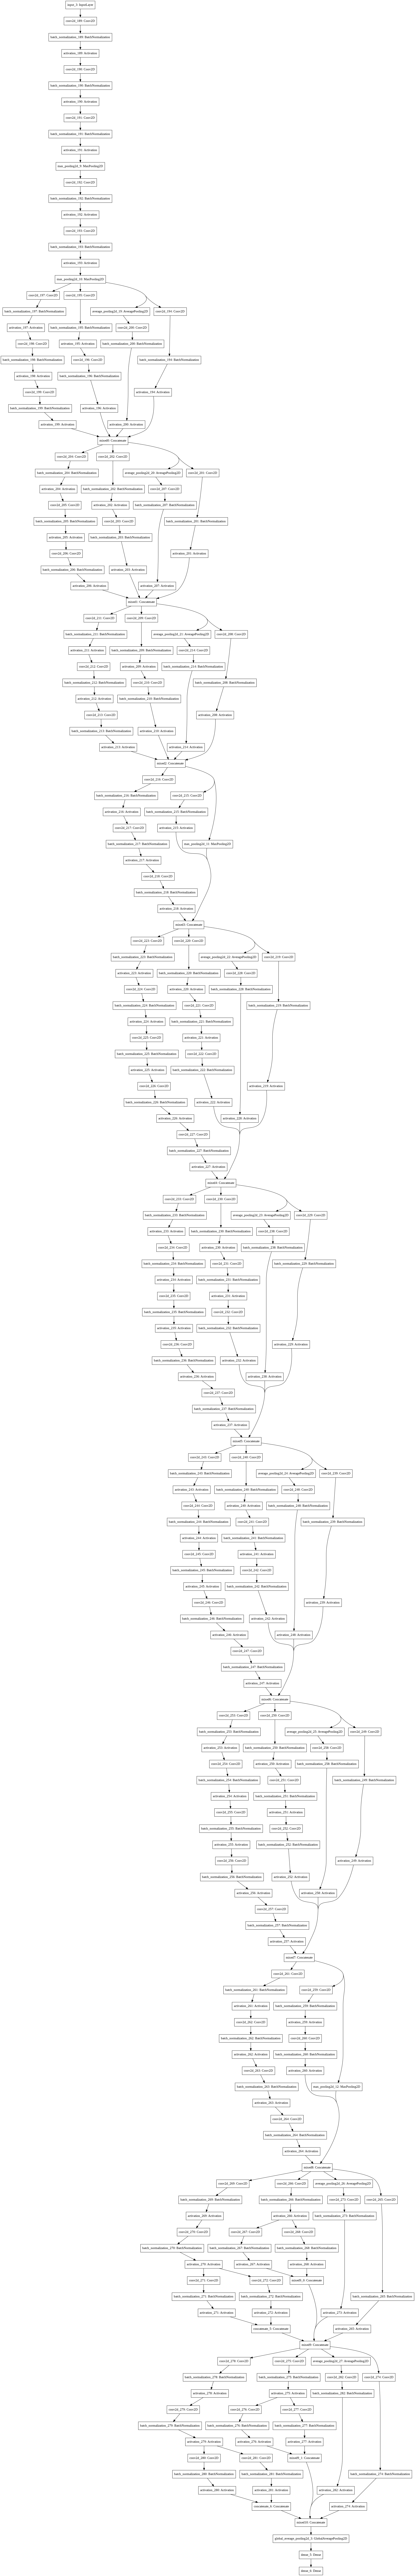

In [30]:
plot_model(model, to_file='model.png')